<a href="https://colab.research.google.com/github/LuciferX45/People-Clothing-Segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **People Clothing Segmentation**

## 1. Setup and Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import cv2
import kagglehub

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set up paths and constants
DATASET_PATH =  kagglehub.dataset_download('rajkumarl/people-clothing-segmentation')
IMAGE_DIR = os.path.join(DATASET_PATH, 'png_images/IMAGES')
MASK_DIR = os.path.join(DATASET_PATH, 'png_masks/MASKS')
CLASSES_FILE = os.path.join(DATASET_PATH, 'labels.csv')

100%|██████████| 616M/616M [00:28<00:00, 22.5MB/s]

Extracting files...


In [4]:
IMAGE_HEIGHT = 544
IMAGE_WIDTH = 824
NUM_CLASSES = 60  # 59 clothing classes + background
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

## 2. Data Loading and Preprocessing

In [5]:
def read_image(image_path):
    """Read and preprocess an image."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    return img

In [6]:
def resize_data(image, mask, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    """Resize image and mask to the specified dimensions."""
    image = tf.image.resize(image, [height, width])
    mask = tf.image.resize(mask, [height, width], method='nearest')
    return image, mask

In [7]:
def augment_data(image, mask):
    """Apply data augmentation to image and mask."""
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random brightness adjustment (only for image, not mask)
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Ensure image values stay in [0, 1]
    image = tf.clip_by_value(image, 0, 1)

    return image, mask

In [8]:
def read_mask(mask_path):
    """Read and preprocess a segmentation mask."""
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # No need to normalize masks as they contain class indices
    return mask

In [9]:
def prepare_sample(image_path, mask_path):
    """Prepare a single sample (image and mask)."""
    image = read_image(image_path)
    mask = read_mask(mask_path)

    # Resize to target dimensions
    image, mask = resize_data(image, mask)

    # Apply augmentation during training
    image, mask = augment_data(image, mask)

    # Convert mask to one-hot encoding
    mask = tf.squeeze(mask)  # Remove the channel dimension
    mask = tf.one_hot(tf.cast(mask, tf.int32), NUM_CLASSES)

    return image, mask

In [10]:
def create_dataset(image_paths, mask_paths):
    """Create a TensorFlow dataset from image and mask paths."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(prepare_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
# Create a function to read and process the image and mask
def load_data():
    """
    Load images and masks from the dataset and split into training/validation sets.
    Returns: train_dataset, val_dataset, class_names
    """
    # Read class names
    class_df = pd.read_csv(CLASSES_FILE)
    class_names = ['background'] + class_df['label_list'].tolist()

    # Get all image filenames
    image_files = sorted([os.path.join(IMAGE_DIR, fname) for fname in os.listdir(IMAGE_DIR)
                          if fname.endswith('.png')])
    mask_files = sorted([os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR)
                         if fname.endswith('.png')])

    # Ensure we have matching number of images and masks
    assert len(image_files) == len(mask_files), "Number of images and masks don't match!"
    print(f"Found {len(image_files)} images and masks")

    # Split data into training and validation sets
    train_img_files, val_img_files, train_mask_files, val_mask_files = train_test_split(
        image_files, mask_files, test_size=VALIDATION_SPLIT, random_state=42
    )

    print(f"Training set: {len(train_img_files)} images")
    print(f"Validation set: {len(val_img_files)} images")

    # Create TensorFlow datasets
    train_dataset = create_dataset(train_img_files, train_mask_files)
    val_dataset = create_dataset(val_img_files, val_mask_files)

    return train_dataset, val_dataset, class_names


## 3. Model Architecture

In [12]:
def build_model():
    """
    Build a simpler U-Net model for semantic segmentation.
    This implementation avoids dimension matching issues.
    Returns: Compiled model
    """
    # Define input layer
    inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Contracting path (encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = layers.Dropout(0.2)(c4)  # Add dropout for regularization

    # Expansive path (decoder)
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Output layer
    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)]
    )

    return model

## 4. Visualization Helpers

In [13]:
def plot_training_history(history):
    """Plot training and validation loss and IoU."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_io_u'], label='Training IoU')
    plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
    plt.title('IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_history.png")
    plt.show()

In [14]:
def plot_evaluation_samples(model, val_data, num_samples=5):
    """Plot sample images, true masks, and predicted masks from validation data."""
    samples = val_data.take(num_samples)
    plt.figure(figsize=(15, 25))
    for i, (image, mask) in enumerate(samples):
        pred_mask = model.predict(image)
        for j in range(min(2, len(image))):
            row = i * 2 + j
            plt.subplot(num_samples * 2, 3, row * 3 + 1)
            plt.imshow(image[j])
            plt.title(f"Image {row + 1}")
            plt.axis('off')
            plt.subplot(num_samples * 2, 3, row * 3 + 2)
            plt.imshow(tf.argmax(mask[j], axis=-1), cmap='nipy_spectral')
            plt.title(f"True Mask {row + 1}")
            plt.axis('off')
            plt.subplot(num_samples * 2, 3, row * 3 + 3)
            plt.imshow(tf.argmax(pred_mask[j], axis=-1), cmap='nipy_spectral')
            plt.title(f"Predicted Mask {row + 1}")
            plt.axis('off')
    plt.tight_layout()
    plt.savefig("validation_results.png")
    plt.show()

In [15]:
# Custom callback to display segmentation results during training
class SegmentationDisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, num_samples=2):
        self.dataset = dataset
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:  # Display every 2 epochs
            samples = self.dataset.take(self.num_samples)
            plt.figure(figsize=(15, 5 * self.num_samples))

            for i, (image, mask) in enumerate(samples):
                # Show original image
                plt.subplot(self.num_samples, 3, i*3 + 1)
                plt.imshow(image[0])
                plt.title(f"Image")
                plt.axis('off')

                # Show ground truth mask (only show the argmax class for visualization)
                plt.subplot(self.num_samples, 3, i*3 + 2)
                plt.imshow(tf.argmax(mask[0], axis=-1), cmap='nipy_spectral')
                plt.title(f"True Mask")
                plt.axis('off')

                # Show predicted mask
                pred_mask = self.model.predict(image)
                plt.subplot(self.num_samples, 3, i*3 + 3)
                plt.imshow(tf.argmax(pred_mask[0], axis=-1), cmap='nipy_spectral')
                plt.title(f"Predicted Mask")
                plt.axis('off')

            plt.tight_layout()
            plt.savefig(f"segmentation_epoch_{epoch}.png")
            plt.close()

## 5. Training

In [16]:
# Training function
def train_model(model, train_data, val_data):
    """
    Train the model on the training set and validate on the validation set.
    """
    # Set up callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_model.h5", save_best_only=True, monitor="val_mean_io_u"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        SegmentationDisplayCallback(val_data)
    ]

    # Train the model
    history = model.fit(
        train_data,
        epochs=EPOCHS,
        validation_data=val_data,
        callbacks=callbacks
    )

    return history

## 6. Evaluation

In [17]:
# Evaluation function
def evaluate_model(model, val_data, class_names):
    """
    Evaluate the model on the validation set and display metrics.
    """
    print("Evaluating model on validation set...")
    results = model.evaluate(val_data)

    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Mean IoU: {results[2]:.4f}")

    return results

## 7. Main Function

In [18]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load data
print("Loading and preparing dataset...")
train_data, val_data, class_names = load_data()

# Build model
print("Building model...")
model = build_model()
model.summary()

Num GPUs Available:  1
Loading and preparing dataset...
Found 1000 images and masks
Training set: 800 images
Validation set: 200 images
Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 544, 824, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 544, 824, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 544, 824, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 272, 412, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 272, 412, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 272, 412, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 136, 206, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 136, 206, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 136, 206, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 68, 103, 256)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 68, 103, 512)   │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 68, 103, 512)   │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 68, 103, 512)   │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 136, 206, 256)  │        524,544 │ dropout[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 136, 206, 512)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 136, 206, 256)  │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 136, 206, 256)  │        590,080 │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 7,701,180 (29.38 MB)

 Trainable params: 7,701,180 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train model
print("Training model...")
history = train_model(model, train_data, val_data)

Training model...
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7307 - loss: 1.5585 - mean_io_u: 0.4933

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.7308 - loss: 1.5570 - mean_io_u: 0.4934 - val_accuracy: 0.7721 - val_loss: 1.0172 - val_mean_io_u: 0.5224 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7717 - loss: 1.0195 - mean_io_u: 0.5398 - val_accuracy: 0.7800 - val_loss: 0.9486 - val_mean_io_u: 0.5308 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.7799 - loss: 0.9356 - mean_io_u: 0.5338 - val_accuracy: 0.7848 - val_loss: 0.8866 - val_mean_io_u: 0.5224 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.7870 - loss: 0.8681 - mean_io_u: 0.5333 - val_accuracy: 0.7887 - val_loss: 0.8554 - val_mean_io_u: 0.5261 - learning_rate: 0.0010
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7925 - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7925 - loss: 0.8374 - mean_io_u: 0.5356 - val_accuracy: 0.7938 - val_loss: 0.8223 - val_mean_io_u: 0.5207 - learning_rate: 0.0010
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7961 - loss: 0.8159 - mean_io_u: 0.5372

200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7961 - loss: 0.8159 - mean_io_u: 0.5372 - val_accuracy: 0.7985 - val_loss: 0.8332 - val_mean_io_u: 0.5150 - learning_rate: 0.0010
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8018 - loss: 0.7908 - mean_io_u: 0.5317 - val_accuracy: 0.8033 - val_loss: 0.7817 - val_mean_io_u: 0.5195 - learning_rate: 0.0010
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.8067 - loss: 0.7683 - mean_io_u: 0.5344 - val_accuracy: 0.8055 - val_loss: 0.7705 - val_mean_io_u: 0.5226 - learning_rate: 0.0010
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8096 - loss: 0.7442 - mean_io_u: 0.5359 - val_accuracy: 0.8091 - val_loss: 0.7609 - val_mean_io_u: 0.5289 - learning_rate: 0.0010
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8132 

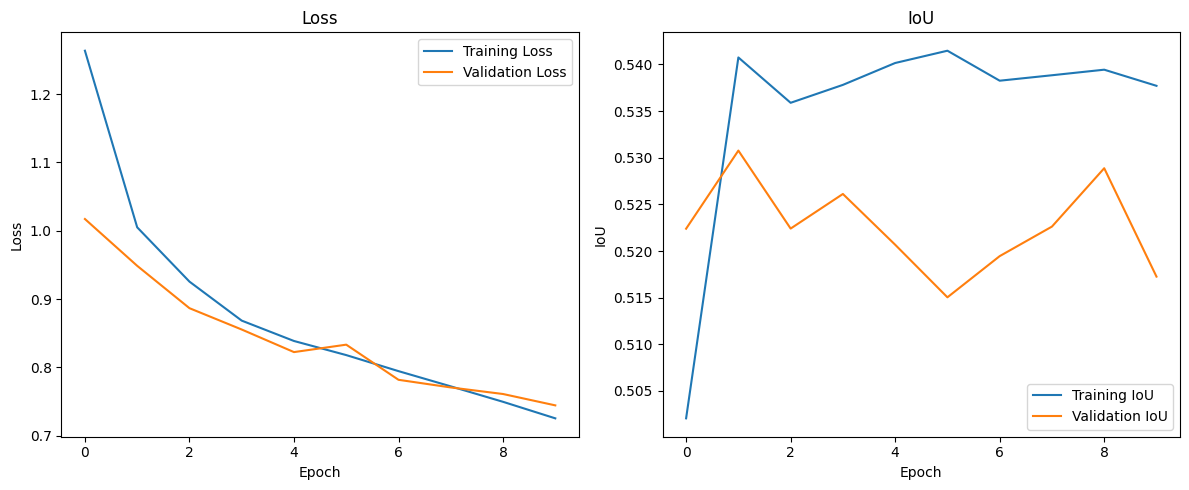

In [20]:
plot_training_history(history)

In [21]:
# Evaluate model
print("Evaluating model...")
results = evaluate_model(model, val_data, class_names)

Evaluating model...
Evaluating model on validation set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 549ms/step - accuracy: 0.8150 - loss: 0.7364 - mean_io_u: 0.5172
Loss: 0.7459
Accuracy: 0.8119
Mean IoU: 0.5174


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


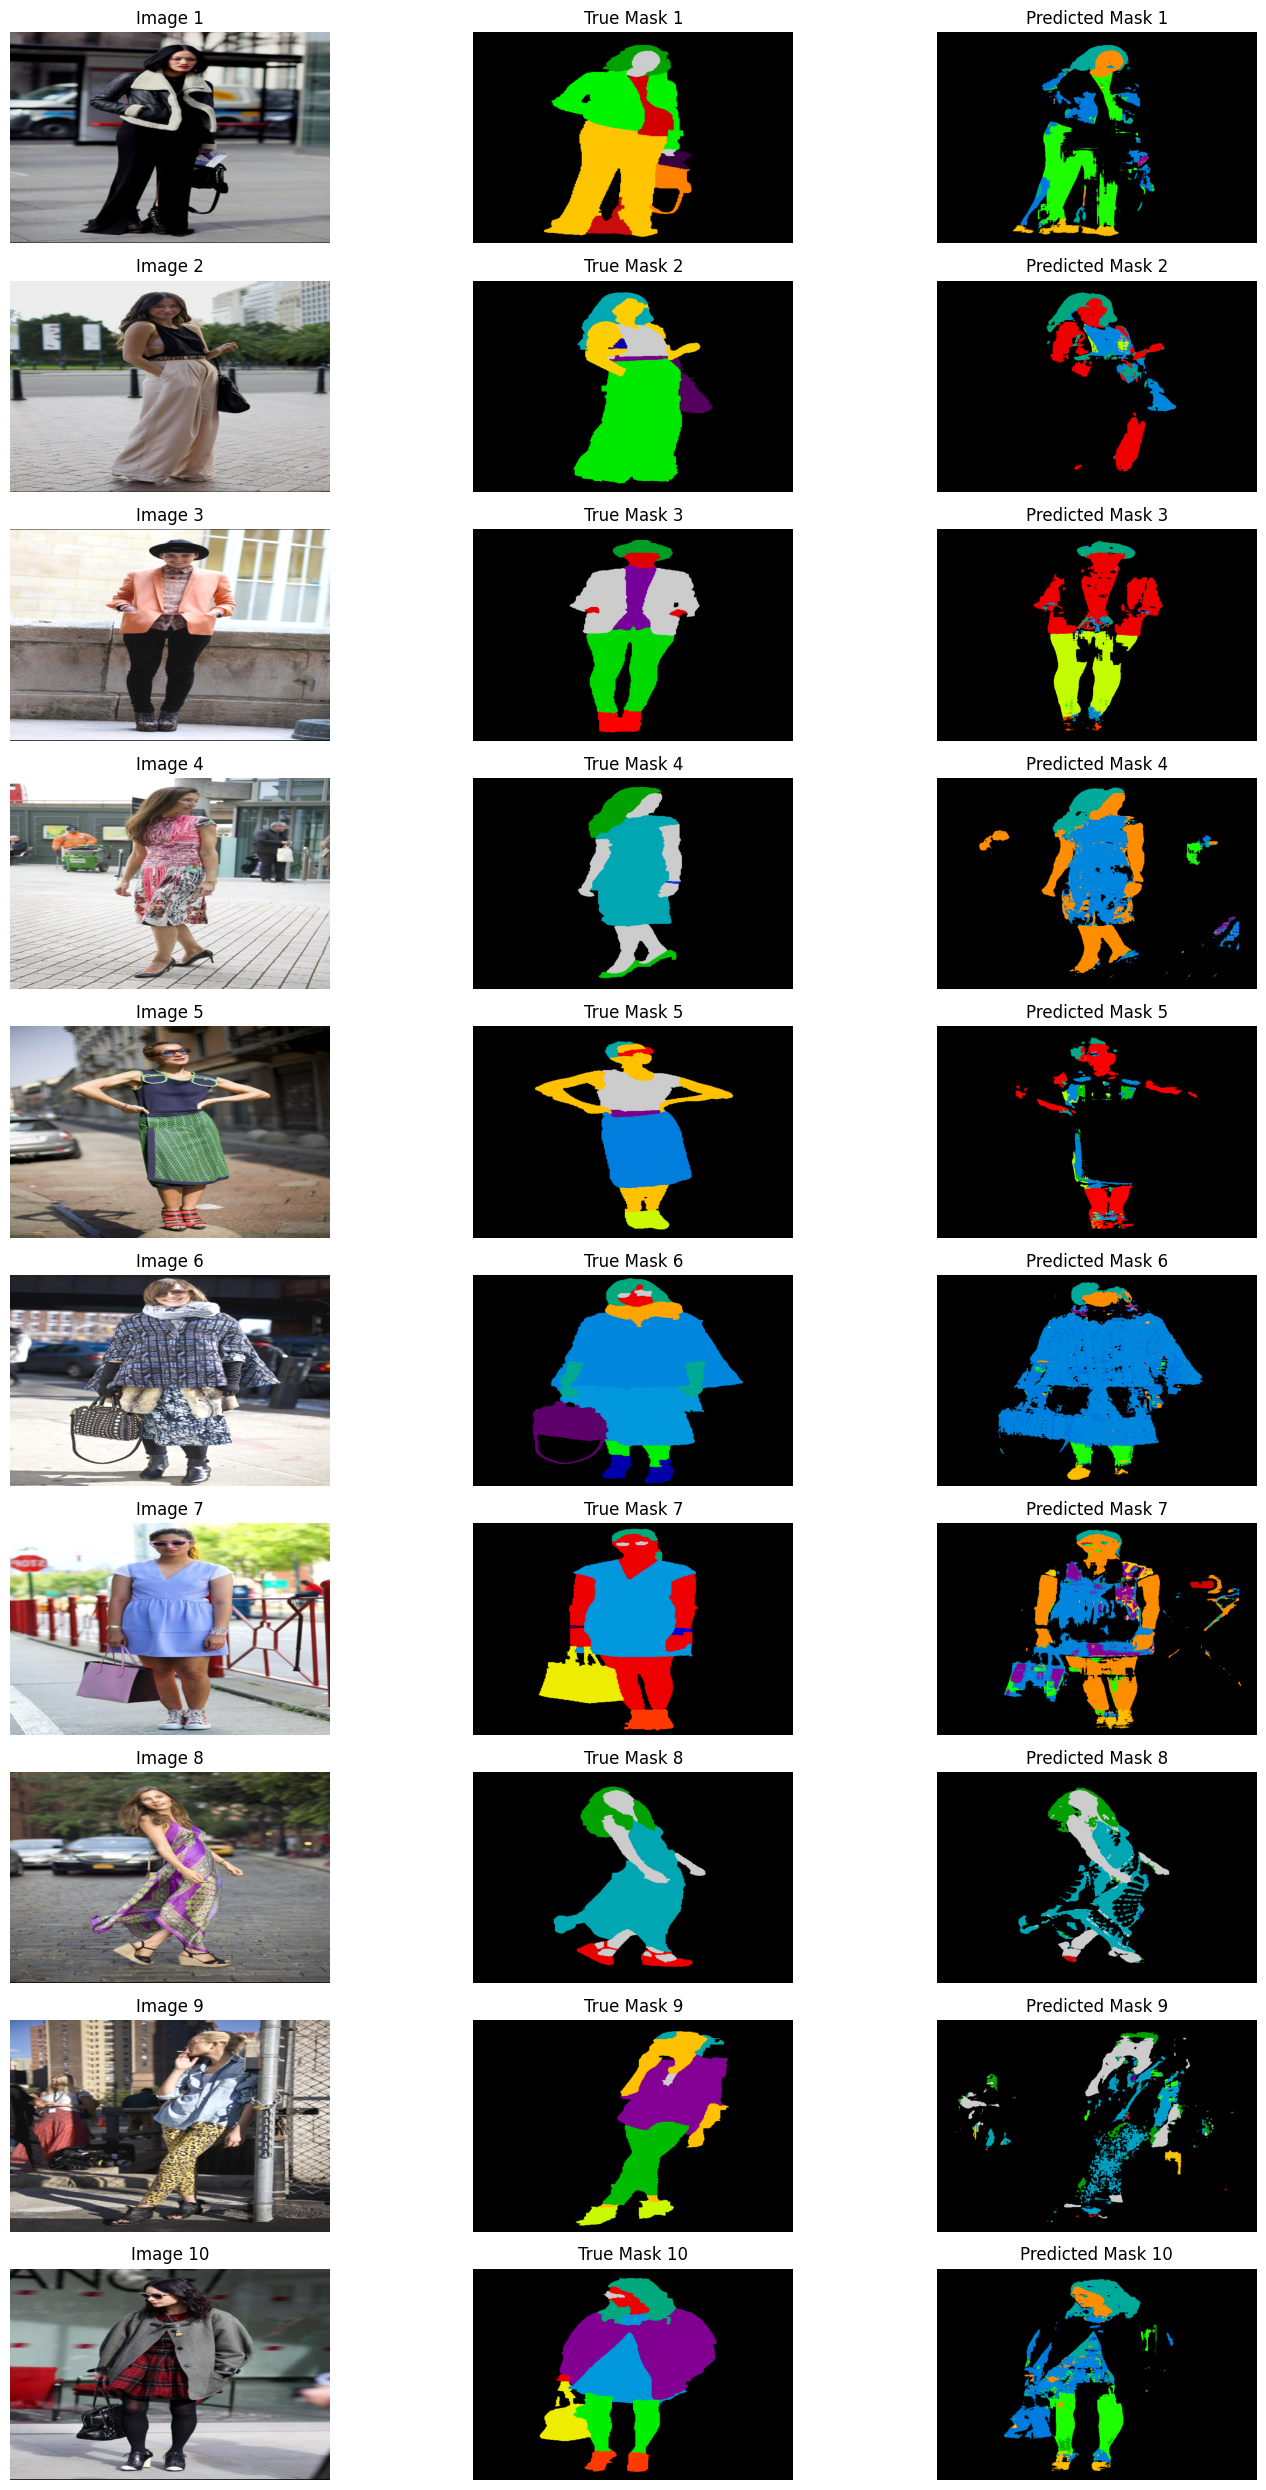

In [22]:
plot_evaluation_samples(model, val_data)

In [23]:
# Save the model
model.save('segmentation_model.h5')
print("Model saved as 'segmentation_model.h5'")

Model saved as 'segmentation_model.h5'


In [24]:

# Export model to TF SavedModel format
tf.saved_model.save(model, 'saved_model')
print("Model exported as SavedModel format in 'saved_model' directory")

Model exported as SavedModel format in 'saved_model' directory
